## Variant 1 (Fear Greed)

In [371]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### Data Collection

In [372]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)
closing_prices = data["Adj Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    """
    Retrieves market prices and market capitalisations for a list of stock tickers. 
    Market prices are retrieved from the Vanguard S&P 500 index (VOO) based on the 
    Adjusted Close column, and market capitalisations are retrieved for each stock.

    Parameters:
    tickers: list of str
        List of stock tickers to retrieve market caps for.
    start_date: str in date format
        Start date for period to retrieve market prices.
    end_date: str in date format
        End date for period to retrieve market prices.

    Returns:
    market_prices: pd.Series
        Pandas Series of market prices for the VOO index.
    market_caps: dict
        Dictionary of tickers (keys) and market capitalisation (values). If a market cap 
        cannot be retrieved, set the value to 'None'.
    """
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_prices, market_caps

data.tail(10)

[*********************100%***********************]  7 of 7 completed


Price                       Adj Close                                     \
Ticker                            AMD        AMZN       INTC        META   
Date                                                                       
2023-12-15 00:00:00+00:00  139.149994  149.970001  45.549953  333.645508   
2023-12-18 00:00:00+00:00  138.899994  154.070007  45.086166  343.308563   
2023-12-19 00:00:00+00:00  140.149994  153.789993  46.043346  349.026733   
2023-12-20 00:00:00+00:00  135.470001  152.119995  45.155243  347.950867   
2023-12-21 00:00:00+00:00  139.910004  153.839996  46.457798  352.742554   
2023-12-22 00:00:00+00:00  139.600006  153.419998  47.365639  352.045197   
2023-12-26 00:00:00+00:00  143.410004  153.410004  49.832600  353.479706   
2023-12-27 00:00:00+00:00  146.070007  153.339996  50.089161  356.468323   
2023-12-28 00:00:00+00:00  148.759995  153.380005  49.724056  356.956451   
2023-12-29 00:00:00+00:00  147.410004  151.940002  49.585903  352.613037   

Price                                                             Close  \
Ticker                          NVDA       RIVN        TSLA         AMD   
Date                                                                      
2023-12-15 00:00:00+00:00  48.876144  22.830000  253.500000  139.149994   
2023-12-18 00:00:00+00:00  50.062801  23.799999  252.080002  138.899994   
2023-12-19 00:00:00+00:00  49.589939  24.350000  257.220001  140.149994   
2023-12-20 00:00:00+00:00  48.097359  23.180000  247.139999  135.470001   
2023-12-21 00:00:00+00:00  48.976116  23.580000  254.500000  139.910004   
2023-12-22 00:00:00+00:00  48.816162  23.209999  252.539993  139.600006   
2023-12-26 00:00:00+00:00  49.265030  23.590000  256.609985  143.410004   
2023-12-27 00:00:00+00:00  49.402988  23.730000  261.440002  146.070007   
2023-12-28 00:00:00+00:00  49.507965  23.540001  253.179993  148.759995   
2023-12-29 00:00:00+00:00  49.507965  23.459999  248.479996  147.410004   

Price                                             ...       Open             \
Ticker                           AMZN       INTC  ...       NVDA       RIVN   
Date                                              ...                         
2023-12-15 00:00:00+00:00  149.970001  46.160000  ...  48.194000  22.750000   
2023-12-18 00:00:00+00:00  154.070007  45.689999  ...  49.400002  22.600000   
2023-12-19 00:00:00+00:00  153.789993  46.660000  ...  49.424000  23.959999   
2023-12-20 00:00:00+00:00  152.119995  45.759998  ...  49.654999  24.049999   
2023-12-21 00:00:00+00:00  153.839996  47.080002  ...  48.811001  23.540001   
2023-12-22 00:00:00+00:00  153.419998  48.000000  ...  49.195000  23.730000   
2023-12-26 00:00:00+00:00  153.410004  50.500000  ...  48.967999  23.469999   
2023-12-27 00:00:00+00:00  153.339996  50.759998  ...  49.511002  23.799999   
2023-12-28 00:00:00+00:00  153.380005  50.389999  ...  49.643002  23.680000   
2023-12-29 00:00:00+00:00  151.940002  50.250000  ...  49.813000  23.600000   

Price                                    Volume                       \
Ticker                           TSLA       AMD       AMZN      INTC   
Date                                                                   
2023-12-15 00:00:00+00:00  251.210007  70178600  110039100  84553800   
2023-12-18 00:00:00+00:00  253.779999  45199500   62512800  27895700   
2023-12-19 00:00:00+00:00  253.479996  63739800   43171300  35358800   
2023-12-20 00:00:00+00:00  256.410004  54671700   50322100  38159100   
2023-12-21 00:00:00+00:00  251.899994  47179400   36305700  28320500   
2023-12-22 00:00:00+00:00  256.760010  35370400   29480100  30053700   
2023-12-26 00:00:00+00:00  254.490005  47157400   25067200  60287400   
2023-12-27 00:00:00+00:00  258.350006  49033400   31434700  52148000   
2023-12-28 00:00:00+00:00  263.660004  63800700   27057000  27705200   
2023-12-29 00:00:00+00:00  255.100006  62028200   39789000  29266500   

Price                                                                 

In [398]:
closing_prices.tail(10)

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15 00:00:00+00:00,139.149994,149.970001,45.549953,333.645508,48.876144,22.830000,253.500000
2023-12-18 00:00:00+00:00,138.899994,154.070007,45.086166,343.308563,50.062801,23.799999,252.080002
2023-12-19 00:00:00+00:00,140.149994,153.789993,46.043346,349.026733,49.589939,24.350000,257.220001
2023-12-20 00:00:00+00:00,135.470001,152.119995,45.155243,347.950867,48.097359,23.180000,247.139999
2023-12-21 00:00:00+00:00,139.910004,153.839996,46.457798,352.742554,48.976116,23.580000,254.500000
2023-12-22 00:00:00+00:00,139.600006,153.419998,47.365639,352.045197,48.816162,23.209999,252.539993
2023-12-26 00:00:00+00:00,143.410004,153.410004,49.832600,353.479706,49.265030,23.590000,256.609985
2023-12-27 00:00:00+00:00,146.070007,153.339996,50.089161,356.468323,49.402988,23.730000,261.440002
2023-12-28 00:00:00+00:00,148.759995,153.380005,49.724056,356.956451,49.507965,23.540001,253.179993


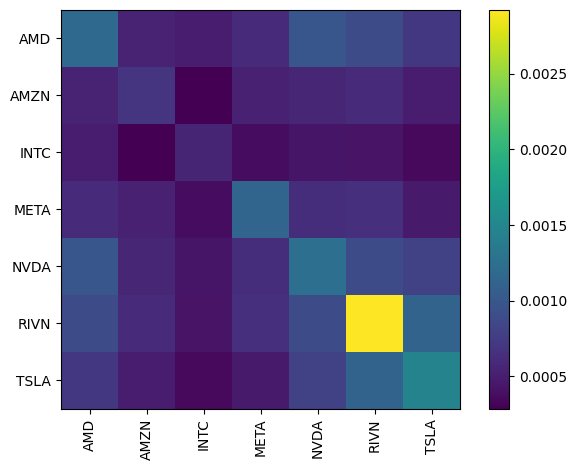

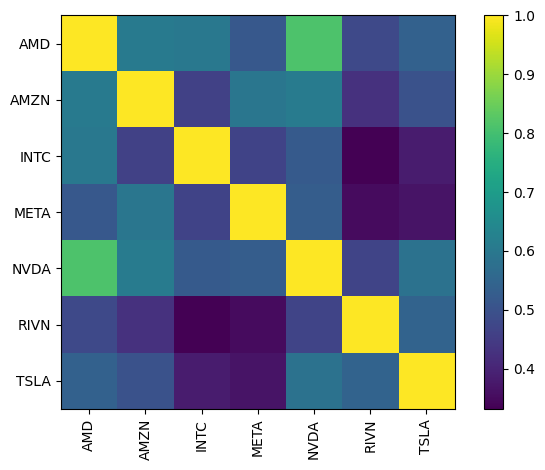

In [374]:
covariance_matrix = returns.cov()

covariance_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=True)

In [375]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


### Get Prior and Delta

In [376]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)

delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

prior

[*********************100%***********************]  1 of 1 completed


Ticker
AMD     0.022677
AMZN    0.022028
INTC    0.021316
META    0.022344
NVDA    0.023093
RIVN    0.022817
TSLA    0.022615
dtype: float64

### Calculate Sentiment Indicators (x5)
#### Calculate Relative Strength Index (RSI)

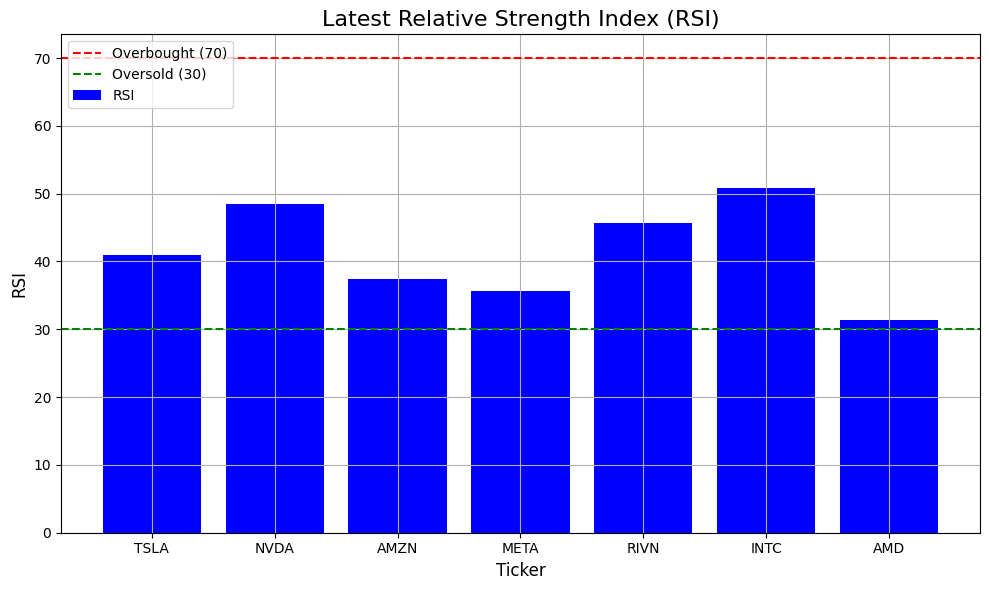

In [ ]:
def calculate_stock_rsi(tickers, period=14):
    """
    Calculates the Relative Strength Index (RSI) values for a list of stocks. 
    Used as a momentum indicator to analyse recent overbought or oversold conditions 
    and the general trend (upward/downward) for a given stock.

    Parameters:
    tickers: list of str
        List of stock tickers.
    period: int
        Lookback period for RSI

    Returns:
    rsi_dict: dict
        Dictionary of tickers with their corresponding RSI value. Higher values indicate
        a stronger upward trend, versus lower values indicating a downtrend.
    """
    if not isinstance(tickers, list):
        print("tickers must be a list of strings")
        return None

    rsi_dict = {}
    for ticker in tickers:
        try:
            stock_data = yf.Ticker(ticker).history(period="1y")

            stock_data['Change'] = stock_data['Close'].diff()

            stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
            stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)

            stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
            stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

            stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
            stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

            rsi_dict[ticker] = stock_data['RSI'].iloc[-1]
        
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating RSI")
            rsi_dict[ticker] = None

    return rsi_dict

def plot_stock_rsi(tickers, period=14):
    """
    Plots the Relative Strength Index (RSI) values for a list of stocks on a
    single bar chart. With a red dashed line indicating overbought, and a green
    dashed line indicating oversold conditions.

    Parameters:
    tickers: list of str
        List of stock tickers.
    period: int (defaults to 14 days)
        Lookback period for RSI
    """
    rsi_dict = calculate_stock_rsi(tickers, period)
    valid_rsi = {ticker: rsi for ticker, rsi in rsi_dict.items() if rsi is not None}

    if not valid_rsi:
        print("No valid RSI data available for plotting.")
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    tickers = list(valid_rsi.keys())
    rsi_values = list(valid_rsi.values())

    ax.bar(tickers, rsi_values, color='blue', label='RSI')
    ax.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax.set_title('Latest Relative Strength Index (RSI)', fontsize=16)
    ax.set_xlabel('Ticker', fontsize=12)
    ax.set_ylabel('RSI', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_stock_rsi(tickers)

#### Stock Price Strength

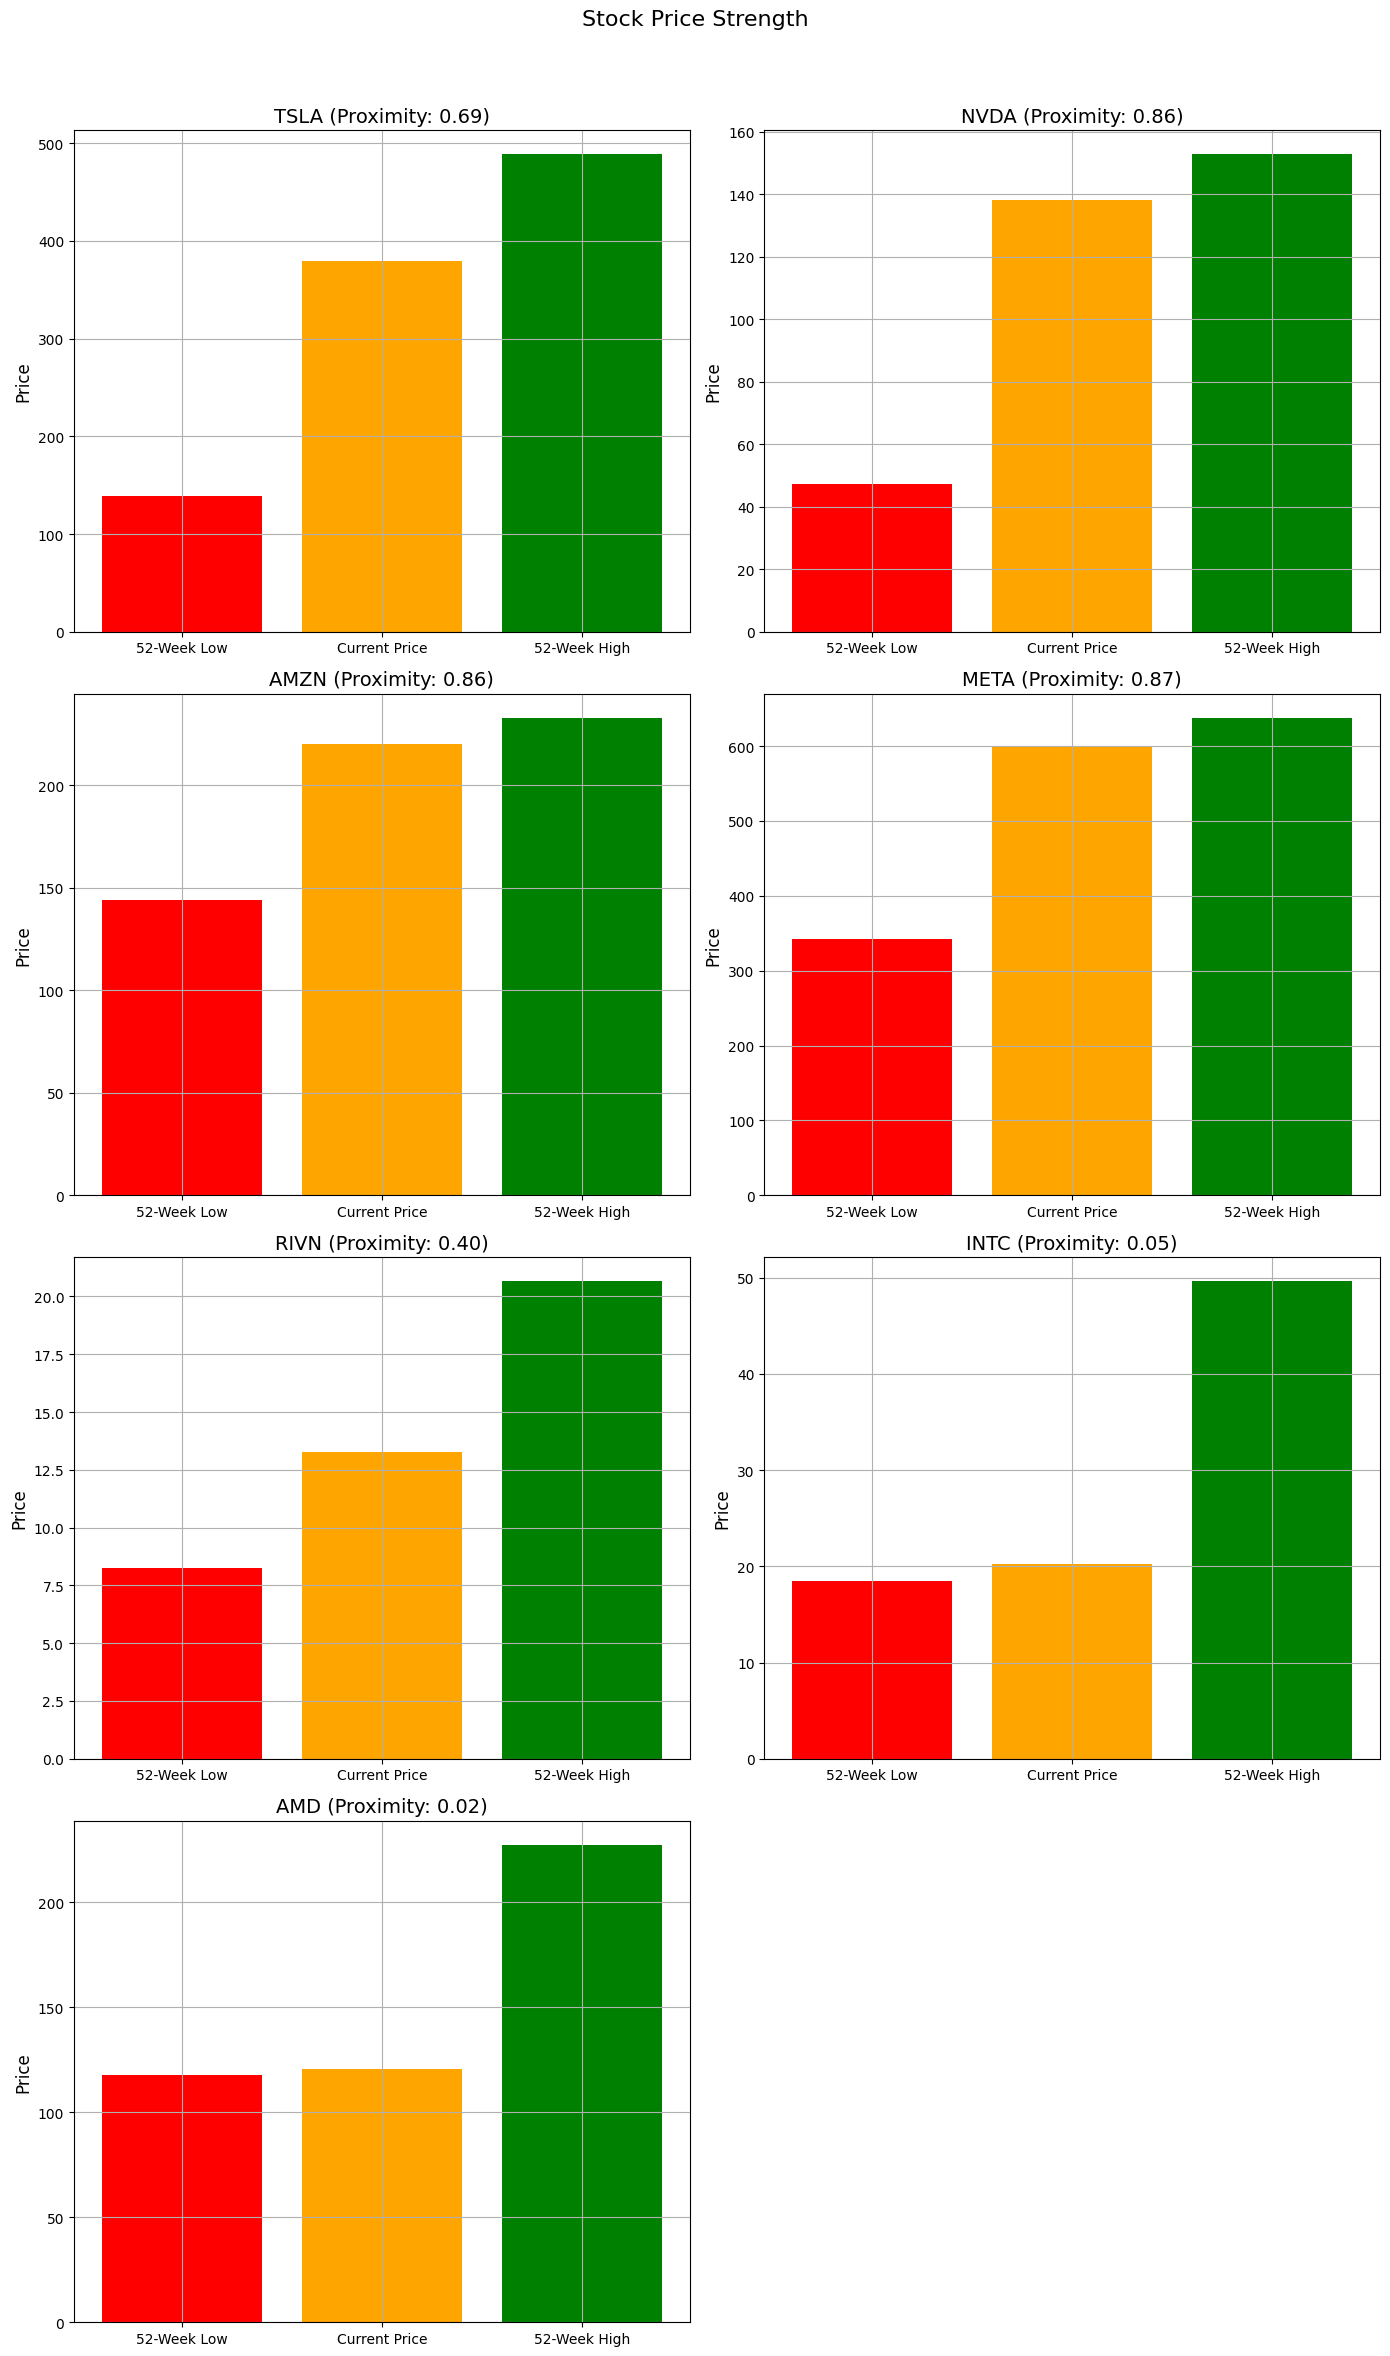

In [ ]:
def calculate_stock_price_strength(tickers):
    """
    Calculates the Relative Price Strength, indicating whether the stock
    is currently outperforming the market (used as a benchmark) based on the
    price in proximity with its 52-week high.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    price_strength_dict: dict
        Tuple of tickers with their corresponding price strength value, including
        price strength, high, low, and current price or 'None' if the value is 0.
    """
    price_strength_dict = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker).history(period="1y")

            high = stock_data['High'].max()
            low = stock_data['Low'].min()
            current_price = stock_data['Close'].iloc[-1]

            # Proximity to 52-week high
            price_strength = (current_price - low) / (high - low) if high - low != 0 else None

            price_strength_dict[ticker] = (price_strength, high, low, current_price)

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating price strength")
            price_strength_dict[ticker] = None

    return price_strength_dict

def plot_stock_price_strength(tickers):
    """
    Plots the Stock Price Strength for each ticker on a bar chart subplot. Includes
    a heading of the ticker and it's proximity to the stock's 52-week high. Bar chart includes
    52-week low, 52-week high, and current price.

    Parameters:
    tickers: list of str
        List of stock tickers.
    """
    price_strength_dict = calculate_stock_price_strength(tickers)

    nrows = (len(tickers) + 1) // 2
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows), sharex=False)
    fig.suptitle('Stock Price Strength', fontsize=16)
    axes = axes.flatten()

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        data = price_strength_dict.get(ticker)

        if data is not None:
            price_strength, high, low, current_price = data
            ax.bar(['52-Week Low', 'Current Price', '52-Week High'], [low, current_price, high], color=['red', 'orange', 'green'])
            ax.set_title(f"{ticker} (Proximity: {price_strength:.2f})", fontsize=14)
            ax.set_ylabel('Price', fontsize=12)
            ax.grid(True)
        else:
            ax.set_title(f"{ticker} (Error)")
            ax.text(0.5, 0.5, "Error: Unable to fetch data", transform=ax.transAxes, fontsize=12, color="red", ha="center", va="center")
            ax.axis("off")

    # Remove surplus subplots
    for j in range(len(tickers), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_stock_price_strength(tickers)

#### Stock Price Breadth

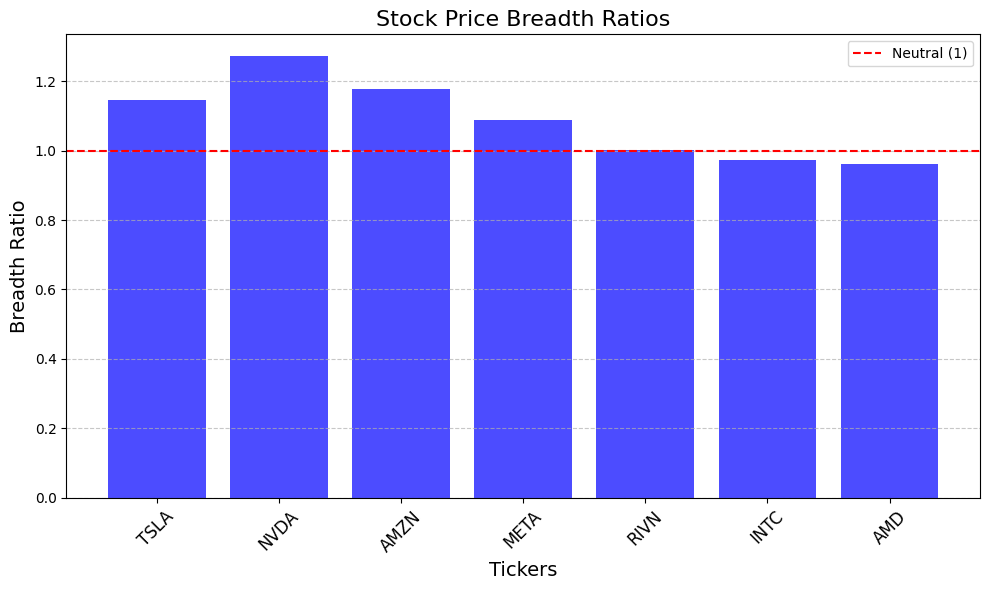

In [ ]:
def calculate_stock_price_breadth(tickers):
    """
    Calculates the Stock Price Breadth which indicates the advancing
    versus declining stock price.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    breadth_ratios: dict
        Dictionary of tickers with their corresponding breadth ratio.
    """
    breadth_ratios = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker)
            prior_year_history = stock_data.history(period="1y")

            close_data = prior_year_history['Close'].tolist()
            volume_data = prior_year_history['Volume'].tolist()

            rising_vol = 0
            declining_vol = 0

            for i in range(1, len(close_data)):
                price_change = close_data[i] - close_data[i - 1]
                if price_change > 0:
                    rising_vol += volume_data[i]
                elif price_change < 0:
                    declining_vol += volume_data[i]

            # edge case for declining_vol == 0
            if declining_vol == 0:
                breadth_ratio = float('inf') if rising_vol > 0 else 0
            else:
                breadth_ratio = rising_vol / declining_vol

            breadth_ratios[ticker] = breadth_ratio

        except Exception as error:
            print(f"An error occurred for {ticker}: {error}")
            breadth_ratios[ticker] = None

    return breadth_ratios

def plot_stock_price_breadth(tickers):
    """
    Plots the Stock Price Breadth for each ticker on a single bar chart.
    Includes a neutral line (red dashed) for reference.

    Parameters:
    tickers: list of str
        List of stock tickers.
    """
    breadth_ratios = calculate_stock_price_breadth(tickers)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(breadth_ratios.keys(), breadth_ratios.values(), color="blue", alpha=0.7)

    ax.set_title("Stock Price Breadth Ratios", fontsize=16)
    ax.set_ylabel("Breadth Ratio", fontsize=14)
    ax.set_xlabel("Tickers", fontsize=14)
    ax.axhline(1, color="red", linestyle="--", label="Neutral (1)")  # neutral ref line
    ax.legend(loc="upper right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_stock_price_breadth(tickers)

#### Market Volatility

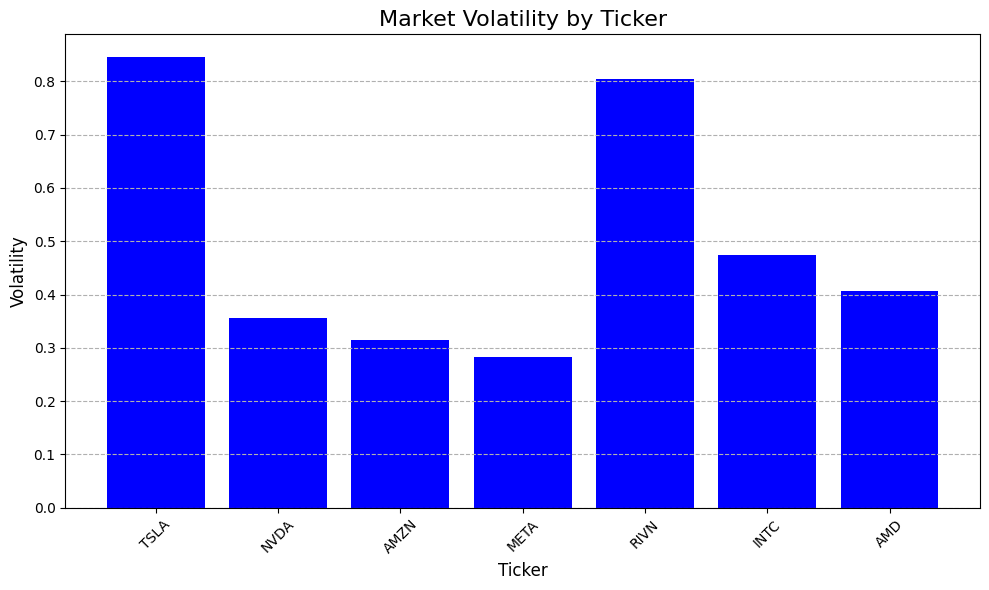

In [ ]:
def calculate_market_volatility(tickers):
    """
    Calculates annual market volatility for a given list tickers 
    based on a rolling 50 day standard deviation of daily returns.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    volatility_dict: dict
        Dictionary of tickers with their corresponding annual
        volatility value. For any errors, this is set to 'None'.
    """
    volatility_dict = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker).history(period="1y")
            stock_data['Returns'] = stock_data['Close'].pct_change()
            stock_data['Volatility'] = stock_data['Returns'].rolling(window=50).std() * np.sqrt(252)
            latest_volatility = stock_data['Volatility'].iloc[-1]
            volatility_dict[ticker] = latest_volatility

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating volatility")
            volatility_dict[ticker] = None

    return volatility_dict

def plot_market_volatility(tickers):
    """
    Plots the market volatility for each ticker on a single bar chart.
    Includes a neutral line (red dashed) for reference.

    Parameters:
    tickers: list of str
        List of stock tickers.
    """
    volatility_dict = calculate_market_volatility(tickers)
    
    # get volatility values
    tickers_list = list(volatility_dict.keys())
    volatility_values = [volatility_dict[ticker] for ticker in tickers_list]

    plt.figure(figsize=(10, 6))
    plt.bar(tickers_list, volatility_values, color='blue')
    plt.title('Market Volatility by Ticker', fontsize=16)
    plt.xlabel('Ticker', fontsize=12)
    plt.ylabel('Volatility', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, axis="y", linestyle="--")
    plt.tight_layout()
    plt.show()

plot_market_volatility(tickers)

#### Put-Call Ratio

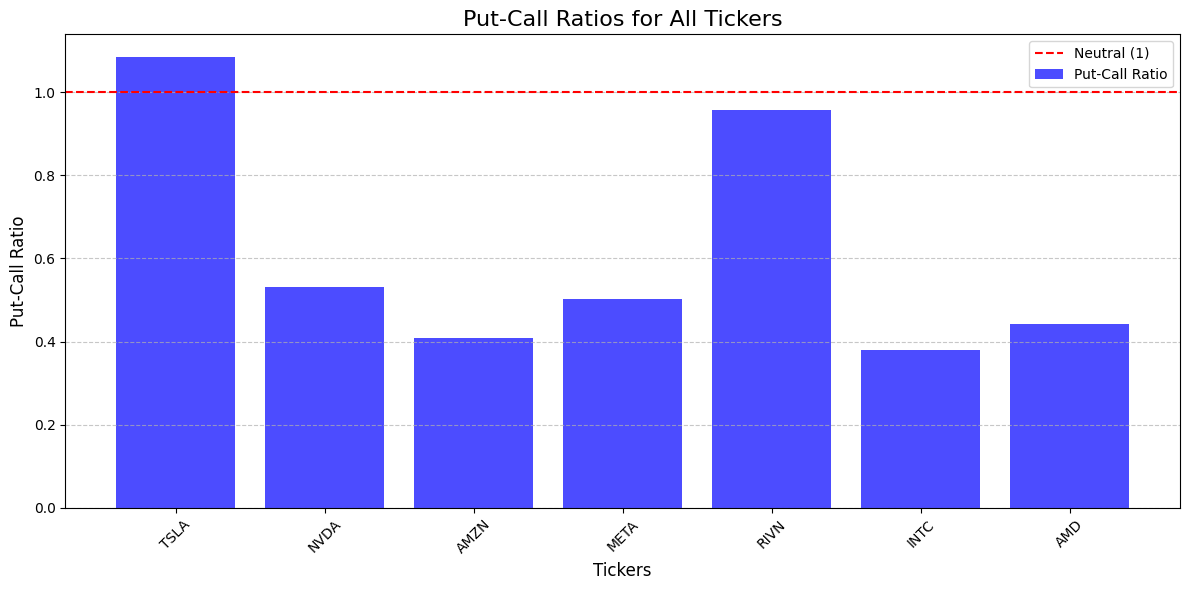

In [381]:
def calculate_put_call_ratio(tickers):
    """
    Calculates the put-call ratio for a given list of tickers
    based on the volume of options.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    put_call_dict: dict
        Dictionary of tickers with their corresponding put-call ratio, 
        calculated as the total put volume divided by total call volume.
        For any errors, this is set to 'None'.
    """
    put_call_dict = {}
    
    for ticker in tickers:
        try:
            # get options chain for ticker
            options = yf.Ticker(ticker).option_chain()
            puts = options.puts
            calls = options.calls

            # total volume
            total_put_volume = puts['volume'].sum()
            total_call_volume = calls['volume'].sum()

            # calculate ratio
            put_call_ratio = total_put_volume / total_call_volume if total_call_volume != 0 else None
            put_call_dict[ticker] = put_call_ratio

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating put-call ratio")
            put_call_dict[ticker] = None
    
    return put_call_dict

def plot_put_call_ratio(tickers):
    """
    Plots the put-call ratio for each ticker on a single bar chart, with
    a neutral reference point (set as 1) marked with a red dashed line.

    Parameters:
    tickers: list of str
        List of stock tickers.
    """
    put_call_dict = calculate_put_call_ratio(tickers)
    valid_data = [(ticker, ratio) for ticker, ratio in put_call_dict.items() if ratio is not None]
    tickers, ratios = zip(*valid_data) if valid_data else ([], [])

    plt.figure(figsize=(12, 6))
    plt.bar(tickers, ratios, color='blue', alpha=0.7, label='Put-Call Ratio')
    plt.axhline(1, color='red', linestyle='--', label='Neutral (1)')  # Neutral line at ratio = 1
    plt.title('Put-Call Ratios for All Tickers', fontsize=16)
    plt.xlabel('Tickers', fontsize=12)
    plt.ylabel('Put-Call Ratio', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_put_call_ratio(tickers)

### Get Stock-Specific Fear-Greed Score

In [382]:
def get_fear_greed(tickers):
    """
    Calculates an overarching fear-greed score based on the individual
    stock sentiment indicators. First retrieves individual values, then
    normalises each value to the same scale. Sets the weight of each indicator,
    then times this by the respective normalised value.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    fear_greed_scores_dict: dict
        Dictionary of tickers with their corresponding amalgamated fear-greed score.
        For any errors, this is set to 'None'.
    """
    fear_greed_scores_dict = {}

    # call indivdual sentiment function
    rsi_dict = calculate_stock_rsi(tickers)
    price_strength_dict = calculate_stock_price_strength(tickers)
    breadth_dict = calculate_stock_price_breadth(tickers)
    volatility_dict = calculate_market_volatility(tickers)
    put_call_ratio_dict = calculate_put_call_ratio(tickers)

    for ticker in tickers:
        try:
            # get all dict values
            rsi = rsi_dict.get(ticker, None)
            price_strength_tuple = price_strength_dict.get(ticker, None)  # Get the whole tuple
            breadth_ratio = breadth_dict.get(ticker, None)
            volatility = volatility_dict.get(ticker, None)
            put_call_ratio = put_call_ratio_dict.get(ticker, None)

            # get price_strength from tuple (price_strength, high, low, current_price)
            price_strength = price_strength_tuple[0] if price_strength_tuple else None

            # normalize each indicator with validation
            normalised_rsi = float(rsi) / 100 if rsi is not None and isinstance(rsi, (int, float)) else 0.5
            normalised_price_strength = float(price_strength) if price_strength is not None and isinstance(price_strength, (int, float)) else 0.5
            normalised_breadth = min(max(float(breadth_ratio) / 2, 0), 1) if breadth_ratio is not None and isinstance(breadth_ratio, (int, float)) else 0.5
            normalised_volatility = min(max(float(volatility) / 100, 0), 1) if volatility is not None and isinstance(volatility, (int, float)) else 0.5
            normalised_put_call_ratio = min(max(float(put_call_ratio), 0), 1) if put_call_ratio is not None and isinstance(put_call_ratio, (int, float)) else 0.5

            print(f"Ticker: {ticker}, RSI: {normalised_rsi}, Strength: {normalised_price_strength}, Breadth: {normalised_breadth}, Volatility: {normalised_volatility}, Put-Call: {normalised_put_call_ratio}")

            # equal weights for each indicator
            rsi_weight = 0.2
            price_strength_weight = 0.2
            breadth_weight = 0.2
            volatility_weight = 0.2
            put_call_ratio_weight = 0.2

            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight +
                normalised_volatility * volatility_weight +
                normalised_put_call_ratio * put_call_ratio_weight
            )

            fear_greed_scores_dict[ticker] = fear_greed_score

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when attempting to calculate the fear-greed score")
            fear_greed_scores_dict[ticker] = None

    return fear_greed_scores_dict

fear_greed_scores_dict = get_fear_greed(tickers)

print(f"\nFear-Greed Scores:\n {fear_greed_scores_dict}")

Ticker: TSLA, RSI: 0.40954464293516407, Strength: 0.6875964772415475, Breadth: 0.5730759859569043, Volatility: 0.008461916936006961, Put-Call: 1
Ticker: NVDA, RSI: 0.4846719924258088, Strength: 0.8619960727057059, Breadth: 0.635474018456378, Volatility: 0.0035536617027075897, Put-Call: 0.5318510484083446
Ticker: AMZN, RSI: 0.37355161491549815, Strength: 0.8563237861971683, Breadth: 0.5889887207318162, Volatility: 0.0031395977880316, Put-Call: 0.4095527519415539
Ticker: META, RSI: 0.3557850528343887, Strength: 0.8694459843230253, Breadth: 0.5439595938323534, Volatility: 0.002819989169639353, Put-Call: 0.5030715844222764
Ticker: RIVN, RSI: 0.45626070020961207, Strength: 0.40241934876040025, Breadth: 0.5008850849602449, Volatility: 0.008045334311884169, Put-Call: 0.957722147187235
Ticker: INTC, RSI: 0.508680419881453, Strength: 0.054939304375246495, Breadth: 0.48668853236369486, Volatility: 0.004745047332605375, Put-Call: 0.37894802095279423
Ticker: AMD, RSI: 0.3133336784008573, Strength:

### Convert to Views (might be able to bypass this step)

In [383]:
# bullish_threshold = 0.45  # should ideally be 0.7 or higher for a clear bullish view
# bearish_threshold = 0.40

# fg_based_views = {}

# for ticker, score in fear_greed_scores_dict.items():
#     if score is not None:
#         if score > bullish_threshold:
#             view_returns = 0.2 + score * 0.0001  # Positive returns for bullish view
#         elif score < bearish_threshold:
#             view_returns = -0.2 + (bearish_threshold - score) * 0.0001  # Negative returns for bearish view
#         else:
#             view_returns = 0.0  #(neutral view)

#         fg_based_views[ticker] = view_returns

#         print(f"Ticker: {ticker}, View: {view_returns}")

# # convert views and confidences to numpy arrays for further processing
# fg_views_array = np.array([value for value in fg_based_views.values() if value != 0.0])
# fg_views_series = pd.Series({ticker: view for ticker, view in fg_based_views.items() if view != 0.0}) # might be needed when calling BL, otherwise remove

# fg_views_series

# print(f"\nViews: {fg_views_array}")

In [384]:
total = sum(fear_greed_scores_dict.values())

normalized_values = {ticker: (value / total) for ticker, value in fear_greed_scores_dict.items()} # normalise to equate to 1
print(normalized_values)

fg_scores_df = pd.DataFrame.from_dict(normalized_values, orient='index', columns=['Normalised Fear-Greed Score'])
fg_scores_df

{'TSLA': 0.18189486667564891, 'NVDA': 0.17095323271125443, 'AMZN': 0.15153314875740395, 'META': 0.15448875013188568, 'RIVN': 0.15790098866543847, 'INTC': 0.09737541435910357, 'AMD': 0.08585359869926507}


,Normalised Fear-Greed Score
TSLA,0.181895
NVDA,0.170953
AMZN,0.151533
META,0.154489
RIVN,0.157901
INTC,0.097375
AMD,0.085854


### Run Black Litterman Model

In [385]:
confidences = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

fear_greed_bl = BlackLittermanModel(
    covariance_matrix,
    pi=prior,
    absolute_views=None,
    Q=fg_scores_df, # what happens if you use the fg score here directly, instead of converting to a view
    P=None, # might not be needed since the views can implicitly be mapped to each ticker
    omega=None,
    view_confidences=confidences,
    tau=0.025,
    risk_aversion=delta
)

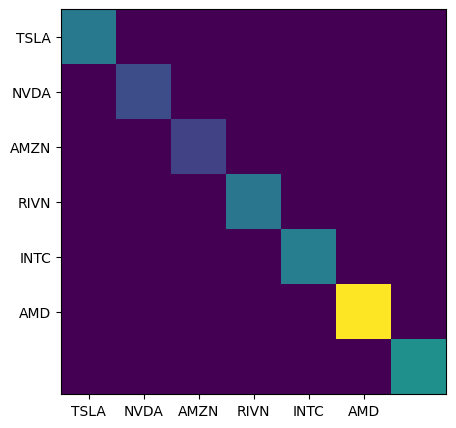

In [401]:
def plot_omega():
    """
    Plots the Black Litterman omega value (view uncertainties)
    for all tickers where a view has been established.
    """
    tickers_with_views = ["TSLA", "NVDA", "AMZN", "RIVN", "INTC", "AMD"]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(fear_greed_bl.omega)

    ax.set_xticks(np.arange(len(tickers_with_views)))
    ax.set_yticks(np.arange(len(tickers_with_views)))

    ax.set_xticklabels(tickers_with_views)
    ax.set_yticklabels(tickers_with_views)
    plt.show()

    np.diag(fear_greed_bl.omega)

plot_omega()

### Calculate Posterior Returns

In [387]:
fear_greed_returns = fear_greed_bl.bl_returns()
fear_greed_returns

Ticker
AMD     0.147020
AMZN    0.119758
INTC    0.107401
META    0.130656
NVDA    0.142079
RIVN    0.118214
TSLA    0.102925
dtype: float64

In [388]:
views_series = pd.Series(normalized_values)

returns_df = pd.DataFrame([prior, fear_greed_returns, views_series], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AMD,0.022677,0.147020,0.085854
AMZN,0.022028,0.119758,0.151533
INTC,0.021316,0.107401,0.097375
META,0.022344,0.130656,0.154489
NVDA,0.023093,0.142079,0.170953
RIVN,0.022817,0.118214,0.157901
TSLA,0.022615,0.102925,0.181895


<Axes: >

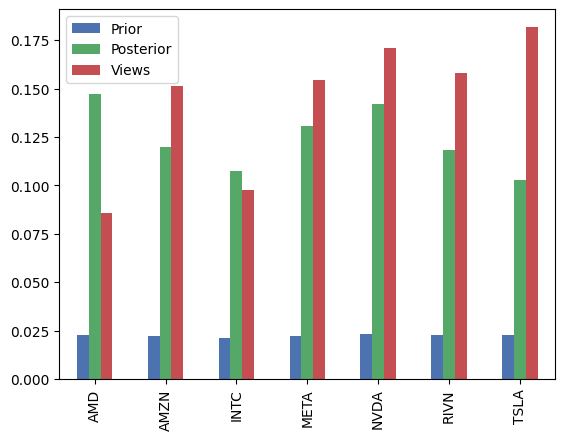

In [399]:
# visualisation of above
returns_df.plot.bar()

<Axes: >

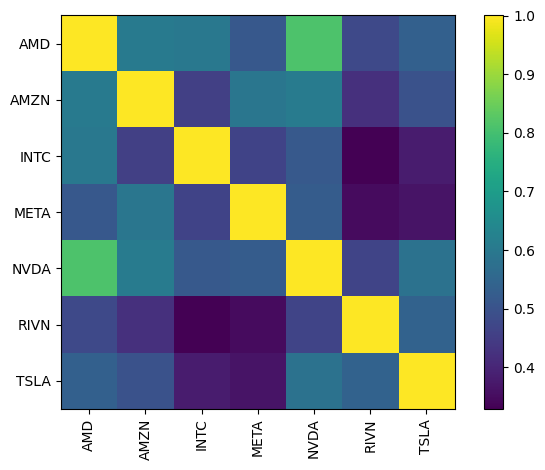

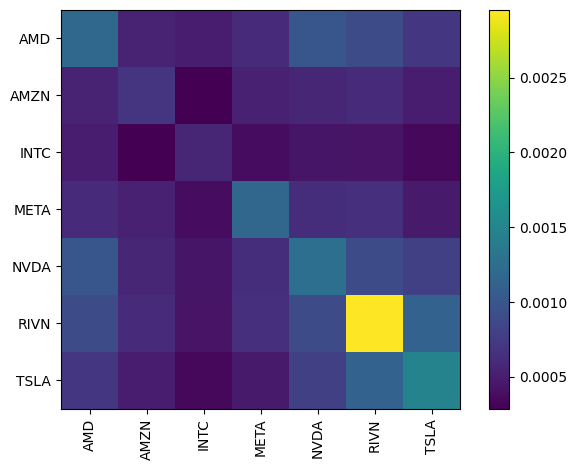

In [390]:
fg_posterior_cov = fear_greed_bl.bl_cov()

plotting.plot_covariance(fg_posterior_cov, plot_correlation=True)
plotting.plot_covariance(fg_posterior_cov, plot_correlation=False)

### Efficient Frontier Weights

#### Minimum Volatility

In [391]:
ef_1 = EfficientFrontier(fear_greed_returns, fg_posterior_cov)
min_vol_weights = ef_1.min_volatility()
cleaned_weights_min_vol = ef_1.clean_weights()

cleaned_weights_min_vol

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.3748),
             ('INTC', 0.57081),
             ('META', 0.01628),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.03811)])

#### Max Sharpe

In [392]:
ef_2 = EfficientFrontier(fear_greed_returns, fg_posterior_cov)
max_sharpe_weights = ef_2.max_sharpe()
cleaned_weights_max_sharpe = ef_2.clean_weights()

cleaned_weights_max_sharpe

OrderedDict([('AMD', 0.12915),
             ('AMZN', 0.34427),
             ('INTC', 0.38092),
             ('META', 0.10482),
             ('NVDA', 0.04084),
             ('RIVN', 0.0),
             ('TSLA', 0.0)])

### Plot Asset Allocation Pies

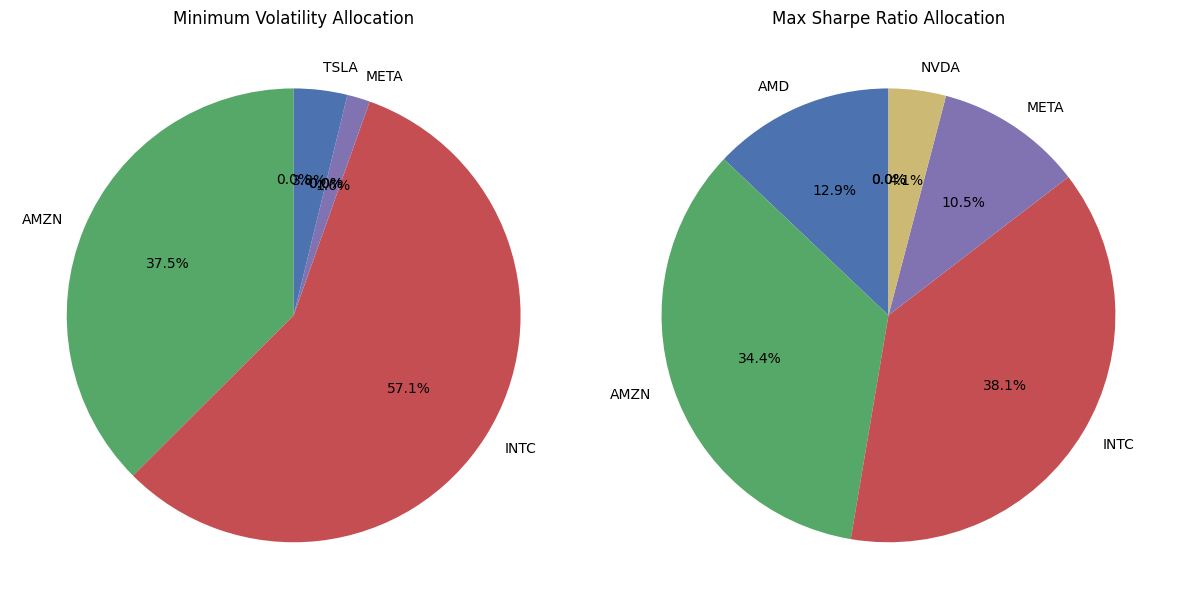

In [393]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Minimum Volaility
pd.Series(cleaned_weights_min_vol).plot.pie(
    ax=axes[0], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Minimum Volatility Allocation"
)

# Plot Max Sharpe
pd.Series(cleaned_weights_max_sharpe).plot.pie(
    ax=axes[1], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Max Sharpe Ratio Allocation"
)

plt.tight_layout()
plt.show()

### Portfolio Performance

#### Minimum Volatility Performance

In [394]:
ef_1.portfolio_performance(verbose=True)

Expected annual return: 11.2%
Annual volatility: 2.1%
Sharpe Ratio: 4.34


(0.11224036109290057, 0.02124609237067309, 4.341521230521617)

#### Max Sharpe Performance

In [395]:
ef_2.portfolio_performance(verbose=True)

Expected annual return: 12.1%
Annual volatility: 2.2%
Sharpe Ratio: 4.49


(0.12062566838604982, 0.022407446582555616, 4.49072445694851)

### Get Discrete Alllocation (DA)

#### Min Volatility DA

In [396]:
latest_prices = get_latest_prices(closing_prices)
da_min_vol = DiscreteAllocation(cleaned_weights_min_vol, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_min_vol.lp_portfolio(verbose=True)

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

Funds remaining: 2.16
AMD: allocated 0.000, desired 0.000
AMZN: allocated 0.380, desired 0.375
INTC: allocated 0.570, desired 0.571
META: allocated 0.000, desired 0.016
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.050, desired 0.038
Allocation has RMSE: 0.008
{'AMZN': 25, 'INTC': 115, 'TSLA': 2}


#### Max Sharpe DA

In [397]:
latest_prices = get_latest_prices(closing_prices)
da_max_sharpe = DiscreteAllocation(cleaned_weights_max_sharpe, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_max_sharpe.lp_portfolio(verbose=True)

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

Funds remaining: 5.77
AMD: allocated 0.133, desired 0.129
AMZN: allocated 0.350, desired 0.344
INTC: allocated 0.377, desired 0.381
META: allocated 0.106, desired 0.105
NVDA: allocated 0.035, desired 0.041
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.000, desired 0.000
Allocation has RMSE: 0.004
{'AMD': 9, 'AMZN': 23, 'INTC': 76, 'META': 3, 'NVDA': 7}
